In [41]:
import h5py
import numpy as np
from scipy.optimize import curve_fit, leastsq, fsolve
from scipy.constants import h, hbar
import matplotlib.pyplot as plt
import os

In [42]:
from datetime import datetime

def sort_hdf5_filenames(filenames):
    """
    Sort a list of filenames in the format 'YYYY-MM-DD_HH_MM_SS.hdf5'
    by their embedded date and time.
    """
    def extract_datetime(filename):
        # Remove extension and parse the datetime
        timestamp_str = filename.replace('.hdf5', '')
        return datetime.strptime(timestamp_str, '%Y-%m-%d_%H_%M_%S')
    
    return sorted(filenames, key=extract_datetime)

In [ ]:
data_file_path = '/home/kth-user/Documents/data/'
fab_name = 'LKIPA_4'
sample = 'LKIPA_4_08-01'
path = os.path.join(data_file_path,fab_name, sample)

meas_list = os.listdir(path)
meas_list = sort_hdf5_filenames(meas_list)
meas = meas_list[-1]

f = h5py.File(os.path.join(path, meas))

test_runs = list(f.keys())
print(test_runs)

['0', '1', '2', '3', '4', '5', 'Source code']


['0', '1', '2', '3', '4', '5', 'Source code']
Sample name: LKIPA_4_08-01
Measurment time: Source code
Temperature: 0.01
Comment Pump_port_connected_DC_port_connected_with_150kOhm


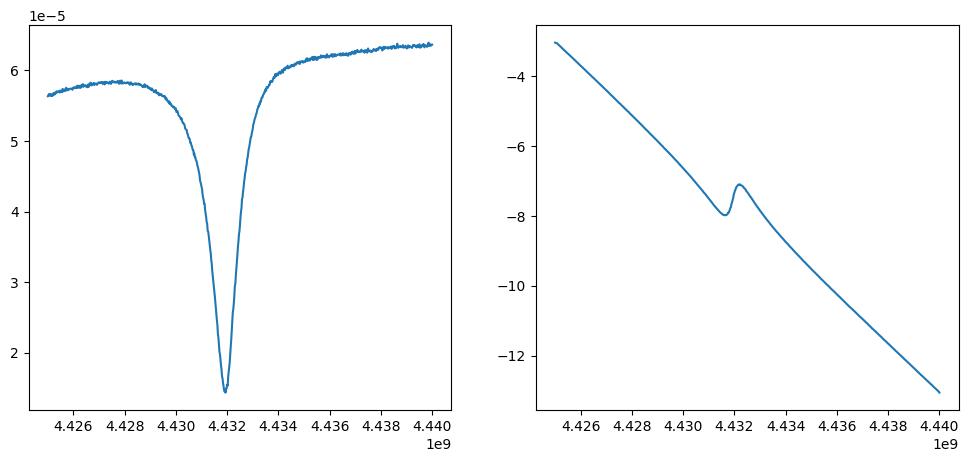

In [44]:
test_runs = list(f.keys())
test_run = test_runs[-1]
print(test_runs)
# test_run = "2025-08-13_15_32_02"
measurements = list(f.keys())

meas_num = 0

S_11_data = f[str(meas_num)]['Data'][()]
meas_freq = f[str(meas_num)]['Frequency'][()]
stepping = f.attrs["Stepping"]
temp = f.attrs["T"]
try:
    comment = f.attrs["Comment"]
except: 
    comment = "no comment recorded"

print(f"Sample name: {sample}")
print(f"Measurment time: {test_run}")
print(f"Temperature: {temp}")
print(f"Comment {comment}")

fig, ax = plt.subplots(1, 2, figsize=(12, 5))

ax[0].plot(meas_freq, np.abs(S_11_data))
ax[1].plot(meas_freq, np.unwrap(np.angle(S_11_data)))


In [45]:
### Plot Method
# 

def reflection_plotting(meas_freq, S_11_data, model_fit: bool = False, fitting_form = None, model_form = None, popt = [None], ReIm = False):
    if ReIm:
        fig, ax = plt.subplots(2, 2, figsize=(12, 10))
        ax[0,0].plot(meas_freq, np.abs(S_11_data))
        ax[0,1].plot(meas_freq, np.angle(S_11_data))

        ax[1,0].plot(meas_freq, np.real(S_11_data))
        ax[1,1].plot(meas_freq, np.imag(S_11_data))

        if model_fit:
            fitted_data = fitting_form(meas_freq, *popt)
            ax[0,0].plot(meas_freq, abs(model_form(meas_freq, *popt)))
            ax[0,1].plot(meas_freq, np.angle(model_form(meas_freq, *popt)))
            ax[1,0].plot(meas_freq, fitted_data[:int(len(fitted_data)/2)])
            ax[1,1].plot(meas_freq, fitted_data[int(len(fitted_data)/2):])

        ax[0,0].set_title("Reflection Magnitude |S11|")
        ax[0,0].set_xlabel("Angular Frequency (Hz)")
        ax[0,0].set_ylabel("|S11|")

        ax[0,1].set_title("Reflection Phase ∠S11")
        ax[0,1].set_xlabel("Angular Frequency (Hz)")
        ax[0,1].set_ylabel("Phase (radians)")
        ax[0,1].grid(True, which='both')

        ax[1,0].set_title("Real part of S11")
        ax[1,0].set_xlabel("Angular Frequency (Hz)")
        ax[1,0].set_ylabel("Re{S11}")

        ax[1,1].set_title("Imaginary part of S11")
        ax[1,1].set_xlabel("Angular Frequency (Hz)")
        ax[1,1].set_ylabel("Im{S11}")
        ax[1,1].grid(True, which='both')
    else:
        fig, ax = plt.subplots(1, 2, figsize=(12, 5))

        ax[0].plot(meas_freq, np.abs(S_11_data))
        ax[1].plot(meas_freq, np.angle(S_11_data))

        if model_fit:
            fitted_data = fitting_form(meas_freq, *popt)
            ax[0].plot(meas_freq, abs(model_form(meas_freq, *popt)))
            ax[1].plot(meas_freq, np.angle(model_form(meas_freq, *popt)))

            ax[0].set_title("Reflection Magnitude |S11|")
            ax[0].set_xlabel("Angular Frequency (Hz)")
            ax[0].set_ylabel("|S11|")

            ax[1].set_title("Reflection Phase ∠S11")
            ax[1].set_xlabel("Angular Frequency (Hz)")
            ax[1].set_ylabel("Phase (radians)")
            ax[1].grid(True, which='both')

phase shift: 3046.781155435403, group delay: 1.0969230013881085e-07


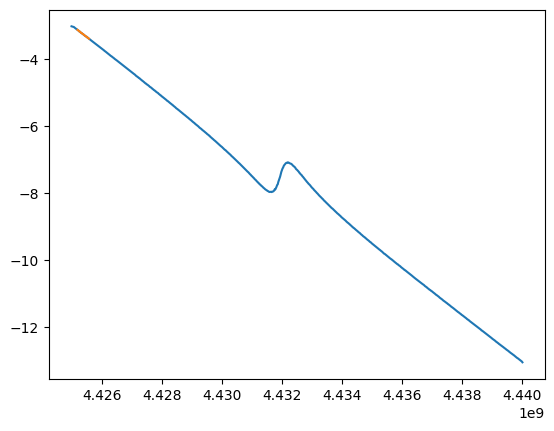

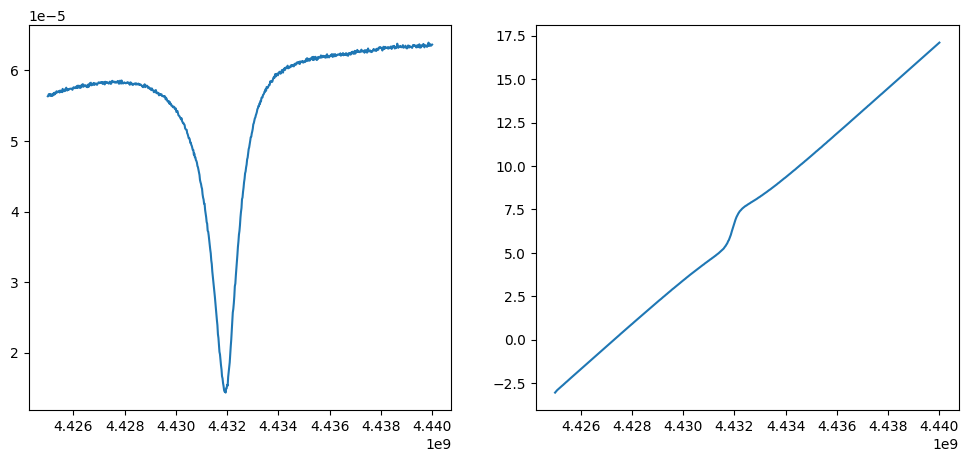

In [46]:
### Find group delay

##phi: phase shift, delay: group delay
def group_delay(freq, phi, delay):
    return phi - 2*np.pi * delay * freq

def correct_delay(S_11_data, meas_freq, delay, phi = 0):
    return S_11_data * np.exp(2*np.pi* 1j * (meas_freq * delay + phi))

S_11_phase_rad_unwrapped = np.unwrap(np.angle(S_11_data))

fit_start = 10 #Choose start and stop to exclude resonance.
fit_stop = 30

plt.plot(meas_freq, S_11_phase_rad_unwrapped)
plt.plot(meas_freq[fit_start: fit_stop], S_11_phase_rad_unwrapped[fit_start: fit_stop])

init_guess = [1600, 4.7e-7]

phase_corr_popt, phase_corr_pcov = curve_fit(group_delay, meas_freq[fit_start:fit_stop], S_11_phase_rad_unwrapped[fit_start:fit_stop], p0 = init_guess)
print(f'phase shift: {phase_corr_popt[0]}, group delay: {phase_corr_popt[1]}')
delay = phase_corr_popt[1]
# delay = 75.5e-9
delay = 3.2e-7

S_11_data_corr = correct_delay(S_11_data, meas_freq, delay)

fig, ax = plt.subplots(1, 2, figsize=(12, 5))

ax[0].plot(meas_freq, np.abs(S_11_data_corr))
ax[1].plot(meas_freq, np.unwrap(np.angle(S_11_data_corr)))

tau: 3.6749140591147323e-08


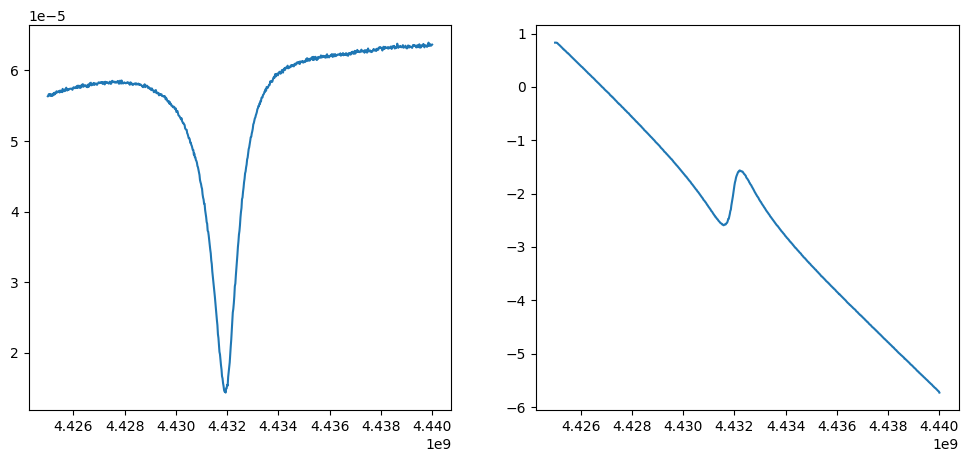

In [47]:
def _fit_circle(z_data, refine_results=False):
    def calc_moments(z_data):
        xi = z_data.real
        xi_sqr = xi*xi
        yi = z_data.imag
        yi_sqr = yi*yi
        zi = xi_sqr+yi_sqr
        Nd = float(len(xi))
        xi_sum = xi.sum()
        yi_sum = yi.sum()
        zi_sum = zi.sum()
        xiyi_sum = (xi*yi).sum()
        xizi_sum = (xi*zi).sum()
        yizi_sum = (yi*zi).sum()
        return np.array([ [(zi*zi).sum(), xizi_sum, yizi_sum, zi_sum],  \
        [xizi_sum, xi_sqr.sum(), xiyi_sum, xi_sum], \
        [yizi_sum, xiyi_sum, yi_sqr.sum(), yi_sum], \
        [zi_sum, xi_sum, yi_sum, Nd] ])

    M = calc_moments(z_data)

    a0 = ((M[2][0]*M[3][2]-M[2][2]*M[3][0])*M[1][1]-M[1][2]*M[2][0]*M[3][1]-M[1][0]*M[2][1]*M[3][2]+M[1][0]*M[2][2]*M[3][1]+M[1][2]*M[2][1]*M[3][0])*M[0][3]+(M[0][2]*M[2][3]*M[3][0]-M[0][2]*M[2][0]*M[3][3]+M[0][0]*M[2][2]*M[3][3]-M[0][0]*M[2][3]*M[3][2])*M[1][1]+(M[0][1]*M[1][3]*M[3][0]-M[0][1]*M[1][0]*M[3][3]-M[0][0]*M[1][3]*M[3][1])*M[2][2]+(-M[0][1]*M[1][2]*M[2][3]-M[0][2]*M[1][3]*M[2][1])*M[3][0]+((M[2][3]*M[3][1]-M[2][1]*M[3][3])*M[1][2]+M[2][1]*M[3][2]*M[1][3])*M[0][0]+(M[1][0]*M[2][3]*M[3][2]+M[2][0]*(M[1][2]*M[3][3]-M[1][3]*M[3][2]))*M[0][1]+((M[2][1]*M[3][3]-M[2][3]*M[3][1])*M[1][0]+M[1][3]*M[2][0]*M[3][1])*M[0][2]
    a1 = (((M[3][0]-2.*M[2][2])*M[1][1]-M[1][0]*M[3][1]+M[2][2]*M[3][0]+2.*M[1][2]*M[2][1]-M[2][0]*M[3][2])*M[0][3]+(2.*M[2][0]*M[3][2]-M[0][0]*M[3][3]-2.*M[2][2]*M[3][0]+2.*M[0][2]*M[2][3])*M[1][1]+(-M[0][0]*M[3][3]+2.*M[0][1]*M[1][3]+2.*M[1][0]*M[3][1])*M[2][2]+(-M[0][1]*M[1][3]+2.*M[1][2]*M[2][1]-M[0][2]*M[2][3])*M[3][0]+(M[1][3]*M[3][1]+M[2][3]*M[3][2])*M[0][0]+(M[1][0]*M[3][3]-2.*M[1][2]*M[2][3])*M[0][1]+(M[2][0]*M[3][3]-2.*M[1][3]*M[2][1])*M[0][2]-2.*M[1][2]*M[2][0]*M[3][1]-2.*M[1][0]*M[2][1]*M[3][2])
    a2 = ((2.*M[1][1]-M[3][0]+2.*M[2][2])*M[0][3]+(2.*M[3][0]-4.*M[2][2])*M[1][1]-2.*M[2][0]*M[3][2]+2.*M[2][2]*M[3][0]+M[0][0]*M[3][3]+4.*M[1][2]*M[2][1]-2.*M[0][1]*M[1][3]-2.*M[1][0]*M[3][1]-2.*M[0][2]*M[2][3])
    a3 = (-2.*M[3][0]+4.*M[1][1]+4.*M[2][2]-2.*M[0][3])
    a4 = -4.

    def func(x):
        return a0+a1*x+a2*x*x+a3*x*x*x+a4*x*x*x*x

    def d_func(x):
        return a1+2*a2*x+3*a3*x*x+4*a4*x*x*x

    x0 = fsolve(func, 0., fprime=d_func)

    def solve_eq_sys(val,M):
        #prepare
        M[3][0] = M[3][0]+2*val
        M[0][3] = M[0][3]+2*val
        M[1][1] = M[1][1]-val
        M[2][2] = M[2][2]-val
        return np.linalg.svd(M)

    U,s,Vt = solve_eq_sys(x0[0],M)

    A_vec = Vt[np.argmin(s),:]

    xc = -A_vec[1]/(2.*A_vec[0])
    yc = -A_vec[2]/(2.*A_vec[0])
    # the term *sqrt term corrects for the constraint, because it may be altered due to numerical inaccuracies during calculation
    r0 = 1./(2.*np.absolute(A_vec[0]))*np.sqrt(A_vec[1]*A_vec[1]+A_vec[2]*A_vec[2]-4.*A_vec[0]*A_vec[3])
    if refine_results:
        print("agebraic r0: " + str(r0))
        xc,yc,r0 = _fit_circle_iter(z_data, xc, yc, r0)
        r0 = _fit_circle_iter_radialweight(z_data, xc, yc, r0)
        print("iterative r0: " + str(r0))
    return xc, yc, r0

def _fit_circle_iter(z_data, xc, yc, rc):
    '''
    this is the radial weighting procedure
    it improves your fitting value for the radius = Ql/Qc
    use this to improve your fit in presence of heavy noise
    after having used the standard algebraic fir_circle() function
    the weight here is: W=1/sqrt((xc-xi)^2+(yc-yi)^2)
    this works, because the center of the circle is usually much less
    corrupted by noise than the radius
    '''
    xdat = z_data.real
    ydat = z_data.imag
    def fitfunc(x,y,xc,yc):
        return np.sqrt((x-xc)**2+(y-yc)**2)
    def residuals(p,x,y):
        xc,yc,r = p
        temp = (r-fitfunc(x,y,xc,yc))
        return temp
    p0 = [xc,yc,rc]
    p_final = leastsq(residuals,p0,args=(xdat,ydat))
    xc,yc,rc = p_final[0]
    return xc,yc,rc
    
def _fit_circle_iter_radialweight(z_data, xc, yc, rc):
    '''
    this is the radial weighting procedure
    it improves your fitting value for the radius = Ql/Qc
    use this to improve your fit in presence of heavy noise
    after having used the standard algebraic fir_circle() function
    the weight here is: W=1/sqrt((xc-xi)^2+(yc-yi)^2)
    this works, because the center of the circle is usually much less
    corrupted by noise than the radius
    '''
    xdat = z_data.real
    ydat = z_data.imag
    def fitfunc(x,y):
        return np.sqrt((x-xc)**2+(y-yc)**2)
    def weight(x,y):
        try:
            res = 1./np.sqrt((xc-x)**2+(yc-y)**2)
        except:
            res = 1.
        return res
    def residuals(p,x,y):
        r = p[0]
        temp = (r-fitfunc(x,y))*weight(x,y)
        return temp
    p0 = [rc]
    p_final = leastsq(residuals,p0,args=(xdat,ydat))
    return p_final[0][0]

def _fit_delay(w_data,z_data,delay=0.,maxiter=0):
        def residuals(p,x,y):
            phasedelay = p
            z_data_temp = y*np.exp(-1j*phasedelay*x)
            xc,yc,r0 = _fit_circle(z_data_temp)
            err = np.sqrt((z_data_temp.real-xc)**2+(z_data_temp.imag-yc)**2)-r0
            return err
        p_final = leastsq(residuals,delay,args=(w_data,z_data),maxfev=maxiter,ftol=1e-15,xtol=1e-15)
        return p_final[0][0]

"""estimate electrical delay"""
# discard=int(len(w)/5)#to get a better estimate extract the slope of the phase from the initial or final section
# _tauR=scipy.stats.linregress(w[-discard:],np.unwrap(np.angle(Y[-discard:])))[0]
# _tauL=scipy.stats.linregress(w[:discard],np.unwrap(np.angle(Y[:discard])))[0]
# _tau=(_tauR+_tauL)/2
_tau = 7.75e-08

# # _tau=-3.8982495291037634e-07
# # _tau=scipy.stats.linregress(w[-discard:],np.unwrap(np.angle(Y[-discard:])))[0]

w = 2*np.pi*meas_freq
discard=int(len(w)/5)

tau=_fit_delay(w[discard:-discard], S_11_data[discard:-discard],delay=_tau,maxiter=20000)
print(f'tau: {tau}')

"""fit actual electrical delay"""
# tau = 7.50e-8

S_11_data_corr = correct_delay(S_11_data, meas_freq, tau)

fig, ax = plt.subplots(1, 2, figsize=(12, 5))

ax[0].plot(meas_freq, np.abs(S_11_data_corr))
ax[1].plot(meas_freq, np.unwrap(np.angle(S_11_data_corr)))

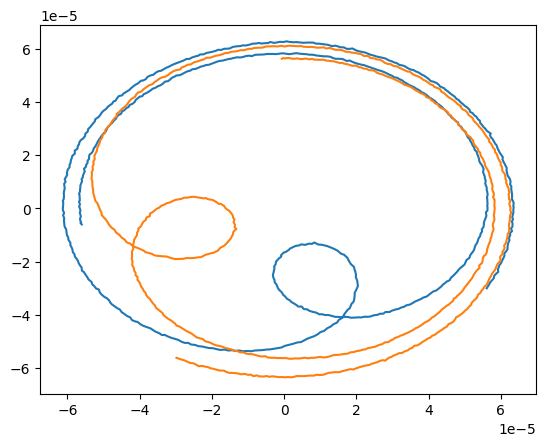

In [48]:
tau = 1.07e-9
# tau = 331.5e-9
S_11_data_corr = correct_delay(S_11_data, meas_freq, tau)
plt.plot(np.real(S_11_data), np.imag(S_11_data))
plt.plot(np.real(S_11_data_corr), np.imag(S_11_data_corr))

4431940000.0 15000000.0
Linear fit of measurement 0: f0 = 4431989376.117946, k0 = 1051190.7435093196, ke = 603570.8433492988, K_tot = 1654761.5868586185, Asym(q) = 68091.23277609385, Baseline(a) = -0.0013642013863912068, Slope(b) = 3.223113364076673e-13, Phase shift = 0.024475319041854623


Text(0.5, 0.98, 'Measurement: Source code')

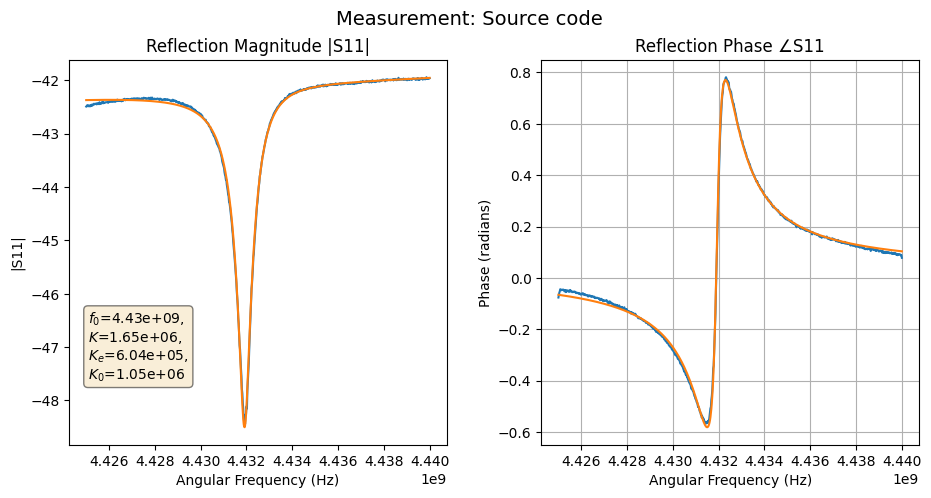

In [49]:
### Fitting low power measurements with linear model

### Model for a linear resonance peak.
def linear_model_form(freq_array, freq0, k0, ke, q, a, b, phi):
    delta = freq_array - freq0
    num = (k0 - ke)/2 + 1j * delta + 1j*q
    den = (k0 + ke)/2 + 1j * delta
    S_11 = ((a + b*freq_array)) * np.exp(1j * phi) * ( num / den - D)
    return S_11

### Splits up the linear model in real and imaginary parts for fitting.
def linear_fitting_form(freq, freq0, k0, ke, q, a, b, phi):
    S_11 = linear_model_form(freq, freq0, k0, ke, q, a, b, phi)
    return np.concatenate([np.real(S_11), np.imag(S_11)])

def guess_losses(freq, S_11):

    S_11_mag = np.abs(S_11)
    
    # Find resonance frequency (minimum in magnitude)
    min_idx = np.argmin(S_11_mag)
    f0_guess = freq[min_idx]

    # Estimate total linewidth (FWHM)
    mag_dip = S_11_mag[min_idx]
    half_max = mag_dip + (1 - mag_dip)/2  # halfway between dip and 1

    indices_below = np.where(S_11_mag < half_max)[0]
    if len(indices_below) >= 2:
        f_low = freq[indices_below[0]]
        f_high = freq[indices_below[-1]]
        kappa_total = f_high - f_low
    else:
        kappa_total = (freq[-1] - freq[0]) / 100  # fallback guess

    return f0_guess, kappa_total

D = 0.05 #directionality, for highly over- or undercoupled measurements this needs to be included.

meas_num = 0

S_11_data = f[str(meas_num)]['Data'][()]
meas_freq = f[str(meas_num)]['Frequency'][()]
# v_amp = f[str(meas_num)].attrs["v_amp"]


if stepping == "pump_amp":
    delay = 331.5e-9
else:
    delay = 1.07e-9
phi = np.pi/2
# delay = 7.75e-8
# delay = 331.5e-9

delay = 1.08e-7

# if DC_bias:
#     S_11_data_corr_scaled = correct_delay(S_11_data, meas_freq, delay)
# else:
#     S_11_data_corr_scaled = correct_delay(S_11_data, meas_freq, delay)/v_amp

S_11_data_corr_scaled = correct_delay(S_11_data, meas_freq, delay, phi)


S_11_real = np.real(S_11_data_corr_scaled)
S_11_imag = np.imag(S_11_data_corr_scaled)

S_11_fitting = np.concatenate([S_11_real, S_11_imag])

f0_guess, k_tot_guess = guess_losses(meas_freq, S_11_data_corr_scaled)
print(f0_guess, k_tot_guess)

# init_guess = [f0_guess, k_tot_guess/4, 3*k_tot_guess/4, 0, 0.45, 0, 0]
init_guess = [f0_guess, 1e6, 3e5, 0, 0.45, 0, 0]
# init_guess = [f0_guess, 1e5, 2e5, 0, 0.45, 0, 0]

lin_popt, lin_pcov = curve_fit(linear_fitting_form, meas_freq, S_11_fitting, p0 = init_guess)

freq0, k0, ke, q, a, b, phi = lin_popt

print(f"Linear fit of measurement {meas_num}: \
f0 = {freq0}, \
k0 = {k0}, \
ke = {ke}, \
K_tot = {k0 + ke}, \
Asym(q) = {q}, \
Baseline(a) = {a}, \
Slope(b) = {b}, \
Phase shift = {phi}")

plot_phase = True
if plot_phase: 
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))

    ax[0].plot(meas_freq, 10*np.log10(np.abs(S_11_data_corr_scaled)))
    ax[1].plot(meas_freq, np.angle(S_11_data_corr_scaled))

    fitted_data = linear_fitting_form(meas_freq, *lin_popt)
    ax[0].plot(meas_freq, 10*np.log10(abs(linear_model_form(meas_freq, *lin_popt))))
    ax[1].plot(meas_freq, np.angle(linear_model_form(meas_freq, *lin_popt)))

    ax[0].set_title("Reflection Magnitude |S11|")
    ax[0].set_xlabel("Angular Frequency (Hz)")
    ax[0].set_ylabel("|S11|")

    ax[1].set_title("Reflection Phase ∠S11")
    ax[1].set_xlabel("Angular Frequency (Hz)")
    ax[1].set_ylabel("Phase (radians)")
    ax[1].grid(True, which='both')

    textstr = fr"$f_0$={freq0:.2e}," + "\n" + rf"$K$={k0 + ke:.2e}," + "\n" + rf"$K_e$={ke:.2e}," + "\n" + rf"$K_0$={k0:.2e}"
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    ax[0].text(0.05, 0.35, textstr, transform=ax[0].transAxes, fontsize=10,
            verticalalignment='top',bbox = props)
    
    fig.subplots_adjust(0.1, 0.11, 0.95, 0.88, 0.25, 0.2)
# reflection_plotting(meas_freq, S_11_data_corr_scaled, True, linear_fitting_form, linear_model_form, lin_popt, ReIm=True)
else:
    fig, ax = plt.subplots(1, 1, figsize=(7, 5))

    ax.plot(meas_freq, 10*np.log10(np.abs(S_11_data_corr_scaled)))

    fitted_data = linear_fitting_form(meas_freq, *lin_popt)
    ax.plot(meas_freq, 10*np.log10(abs(linear_model_form(meas_freq, *lin_popt))))

    ax.set_title("Reflection Magnitude |S11|", fontsize = 14)
    ax.set_xlabel("Angular Frequency (Hz)", fontsize = 14)
    ax.set_ylabel("|S11|", fontsize = 14)

    textstr = fr"$f_0$={freq0:.2e}," + "\n" + rf"$K$={k0 + ke:.2e}," + "\n" + rf"$K_e$={ke:.2e}," + "\n" + rf"$K_0$={k0:.2e}"
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    ax.text(0.05, 0.35, textstr, transform=ax.transAxes, fontsize=14,
            verticalalignment='top',bbox = props)
    fig.subplots_adjust(0.1, 0.15, 0.8, 0.87, 0.2, 0.3)


fig.suptitle(f"Measurement: {test_run}", fontsize = 14)


In [50]:
Q = freq0/(k0 + ke )
Qe = freq0/ke
Q0 = freq0/k0

print(f"Quality factor: {Q}, Internal quality factor: {Q0}, external quality factor: {Qe}")

Quality factor: 2678.325029608396, Internal quality factor: 4216.160961731921, external quality factor: 7342.948097897205


In [52]:

###Fitting higher power measurements with non-linear Kerr model

def Kerr_model_form(freq_array, Kappa):
    n_array = np.array([])
    for freq in freq_array:
        n_array = np.append(n_array, intracavity_photon_number(freq, Kappa))
    delta = freq_array - freq0
    num = (k0 - ke)/2 + 1j * (delta - Kappa * n_array) + 1j*q
    den = (k0 + ke)/2 + 1j * (delta - Kappa * n_array)
    S_11 = ((a + b*freq_array)) * np.exp(1j * phi) * ( num / den - D)
    return S_11

def intracavity_photon_number(freq, Kappa):
    n_in = p_in_W / (h * freq)
    delta = freq - freq0

    #a*n_c**3 + b*n_c**2 + c*n_c + d
    a = Kappa**2
    b = - 2 * Kappa * delta
    c = (delta**2 + (k0 + ke)**2 / 4)
    d = - ke * n_in
    roots = np.roots([a, b, c, d])

    root_list = []
    for root in roots:
        if np.imag(root) == 0.0:
            root_list.append(root)
        else:
            root_list.append(-np.inf)
    n_c = max(root_list)
    if n_c == -np.inf:
        raise ValueError("no real roots")
    else:
        return np.real(n_c)

def Kerr_fitting_form(freq, Kappa):
    S_11 = Kerr_model_form(freq, Kappa)
    return np.concatenate([np.real(S_11), np.imag(S_11)])

meas_num = 0

S_11_data = f[str(meas_num)]['Data'][()]
meas_freq = f[str(meas_num)]['Frequency'][()]

# atten = f.attrs["att"]
atten = 53 + 20 + 30

if stepping != "v_amp" :
    raise Exception("Not correct measurement")
else:
    v_amp = f[str(meas_num)].attrs["v_amp"]
    p_in_dBm = 10*np.log10(v_amp**2) - 20.3 - atten
    p_in_W = 1e-3*10**(p_in_dBm/10)
    S_11_data_corr_scaled = correct_delay(S_11_data, meas_freq, delay)/v_amp

print(v_amp)
print(p_in_dBm)
print(p_in_W)

S_11_real = np.real(S_11_data_corr_scaled)
S_11_imag = np.imag(S_11_data_corr_scaled)

S_11_fitting = np.concatenate([S_11_real, S_11_imag])

init_guess = [-1]

w0 = 2*np.pi*freq0
ke_w = 2*np.pi*ke
k0_w = 2*np.pi*k0

Kerr_popt, Kerr_pcov = curve_fit(Kerr_fitting_form, meas_freq, S_11_fitting, p0 = init_guess)

print(f"Estimated Kerr coefficient from measurement {meas_num}: {Kerr_popt[0]}")

fig, ax = plt.subplots(1, 2, figsize=(12, 5))

ax[0].plot(meas_freq, np.abs(S_11_data_corr_scaled))
ax[1].plot(meas_freq, np.angle(S_11_data_corr_scaled))

fitted_data = Kerr_fitting_form(meas_freq, *Kerr_popt)
ax[0].plot(meas_freq, abs(Kerr_model_form(meas_freq, *Kerr_popt)))
ax[1].plot(meas_freq, np.angle(Kerr_model_form(meas_freq, *Kerr_popt)))

ax[0].set_title("Reflection Magnitude |S11|")
ax[0].set_xlabel("Angular Frequency (Hz)")
ax[0].set_ylabel("|S11|")

ax[1].set_title("Reflection Phase ∠S11")
ax[1].set_xlabel("Angular Frequency (Hz)")
ax[1].set_ylabel("Phase (radians)")
ax[1].grid(True, which='both')


Exception: Not correct measurement

6


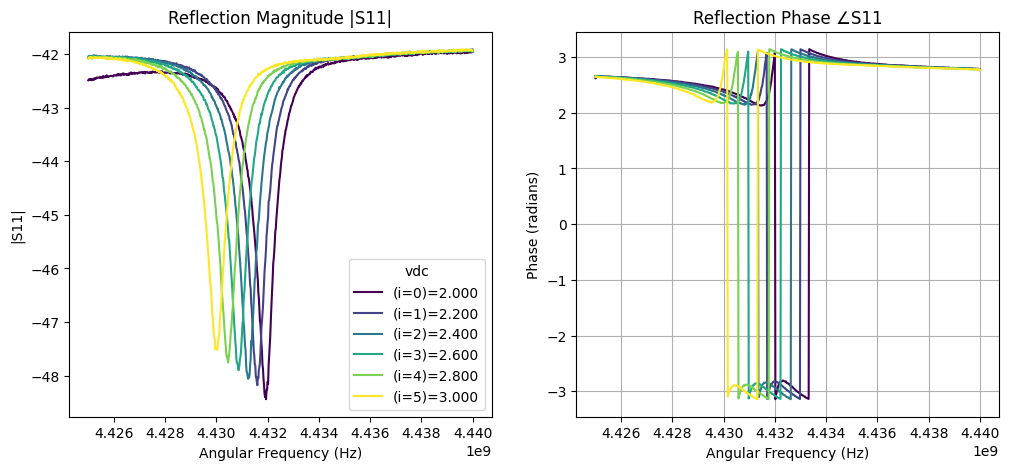

In [53]:
from matplotlib import colormaps as cm


measurements = list(f.keys())

start_num = 0
num_curves = 10
num_curves = len(measurements) - 1
print(num_curves)
cmap = cm['viridis']
legend = []

phi = 0

ReIm = False
if ReIm:
    fig, ax = plt.subplots(2, 2, figsize=(12, 10))
else:
    fig, ax = plt.subplots(1, 2, figsize=(12, 5))

for i in range(start_num, num_curves, 1):
    meas_num = i

    S_11_data = f[str(meas_num)]['Data'][()]
    freq = f[str(meas_num)]['Frequency'][()]

    S_11_data_corr = correct_delay(S_11_data, freq, delay, phi)

    if stepping == "v_amp":
        v_amp = f[str(meas_num)].attrs["v_amp"]
        S_11_data_corr_rel = S_11_data_corr/v_amp
        legend.append(f"(i={i})={v_amp:.3f}")
    elif stepping == "vdc":
        S_11_data_corr_rel = S_11_data_corr
        v_dc = f[str(meas_num)].attrs["vdc"]
        legend.append(f"(i={i})={v_dc:.3f}")
    elif stepping == "pump_amp":
        S_11_data_corr_rel = S_11_data_corr
        pump_amp = f[str(meas_num)].attrs["pump_amp"]
        legend.append(f"(i={i})={pump_amp:.3f}")


    
    color = cmap((i - start_num) / (num_curves - start_num - 1))

    if ReIm:
        ax[0,0].plot(freq, 10*np.log10(np.abs(S_11_data_corr_rel)), color = color)
        ax[0,1].plot(freq, np.angle(S_11_data_corr_rel), color = color)

        ax[1,0].plot(freq, np.real(S_11_data_corr_rel), color = color)
        ax[1,1].plot(freq, np.imag(S_11_data_corr_rel), color = color)

        ax[0,0].set_title("Reflection Magnitude |S11|")
        ax[0,0].set_xlabel("Angular Frequency (Hz)")
        ax[0,0].set_ylabel("|S11|")

        ax[0,1].set_title("Reflection Phase ∠S11")
        ax[0,1].set_xlabel("Angular Frequency (Hz)")
        ax[0,1].set_ylabel("Phase (radians)")
        ax[0,1].grid(True, which='both')

        ax[1,0].set_title("Real part of S11")
        ax[1,0].set_xlabel("Angular Frequency (Hz)")
        ax[1,0].set_ylabel("Re{S11}")

        ax[1,1].set_title("Imaginary part of S11")
        ax[1,1].set_xlabel("Angular Frequency (Hz)")
        ax[1,1].set_ylabel("Im{S11}")
        ax[1,1].grid(True, which='both')
    else:
        ax[0].plot(freq, 10*np.log10(np.abs(S_11_data_corr_rel)), color = color)
        ax[1].plot(freq, np.angle(S_11_data_corr_rel), color = color)

        ax[0].set_title("Reflection Magnitude |S11|")
        ax[0].set_xlabel("Angular Frequency (Hz)")
        ax[0].set_ylabel("|S11|")

        ax[1].set_title("Reflection Phase ∠S11")
        ax[1].set_xlabel("Angular Frequency (Hz)")
        ax[1].set_ylabel("Phase (radians)")
        ax[1].grid(True, which='both')

ax[0].legend(legend, title = f"{stepping}")
fig.savefig("fig_imag0")